## Logistic Regression Modeling and some EDA using: 
### - Transformer: CountVectorizer
### - Lemmatized words

In [1]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Naive Bayes 
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# Logistic Regression 
from sklearn.linear_model import LogisticRegression

# Other Sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, classification_report

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# NLP imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# nltk.download()  --> Download all, and then restart jupyter lab
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import re

### Loading Data and Splitting Data

In [2]:
# Load the data
df = pd.read_csv('../../../data/clean_data/clean_posts.csv', index_col=0)
df.head()

,subreddit,title,created_utc,selftext,title_selftext,author,media_only,permalink,text_length,clean_text_stem,clean_text_lem
0,tolkienfans,What happened to Tolkien’s Red Book?,1616977706,I was wondering if somebody could clear up my ...,what happened to tolkien s red book i was wond...,lukeskinwalker69epic,False,/r/tolkienfans/comments/mfdrms/what_happened_t...,322,happen tolkien red book wonder somebodi could ...,happened tolkien red book wondering somebody c...
1,tolkienfans,What Makes People Turn Invisible When the Put ...,1616971688,I guess this is a big question because I never...,what makes people turn invisible when the put ...,Jpmaniax26,False,/r/tolkienfans/comments/mfbzjh/what_makes_peop...,252,make peopl turn invis put one ring guess big q...,make people turn invisible put one ring guess ...
2,tolkienfans,"Theory: At some point not told in the Tale, Ar...",1616971077,This is the last dialogue between Queen Undómi...,theory at some point not told in the tale arag...,yew_eater,False,/r/tolkienfans/comments/mfbsks/theory_at_some_...,6045,theori point told tale aragorn arwen must seri...,theory point told tale aragorn arwen must seri...
3,tolkienfans,I’d like to purchase a matching set of books o...,1616969977,Can anyone help me out? Looking for matching b...,i d like to purchase a matching set of books o...,GoosePants72,False,/r/tolkienfans/comments/mfbfyj/id_like_to_purc...,302,like purchas match set book everyth lotr silma...,like purchase matching set book everything lot...
4,tolkienfans,"When Faramir ‘proposes’ to Eowyn, something we...",1616966528,After he confesses his love for her and talks ...,when faramir proposes to eowyn something weird...,PhendranaDrifter,False,/r/tolkienfans/comments/mfaae8/when_faramir_pr...,731,faramir propos eowyn someth weird happen confe...,faramir proposes eowyn something weird happens...


In [3]:
# Checks baseline
df['subreddit'].value_counts(normalize=True)
# df['subreddit'].value_counts()

tolkienfans    0.516823
harrypotter    0.483177
Name: subreddit, dtype: float64

In [5]:
# Set up X and y
X = df['clean_text_lem']
y = df['subreddit']

In [6]:
# Splits the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    random_state=42)

### Modeling

In [8]:
# Baseline accuracy 
y_test.value_counts(normalize=True)

tolkienfans    0.516821
harrypotter    0.483179
Name: subreddit, dtype: float64

In [9]:
# Instantiates a pipeline 
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [10]:
# Creates the pipe parameters 
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df':[1, 2],
    'cvec__max_df':[0.90, 0.98],
    'cvec__ngram_range':[(1,1), (1,2)]
}

In [11]:
# Instantiates the GridSearchCV
gs = GridSearchCV(pipe, 
                param_grid=pipe_params,
                cv=5, 
                verbose=1,
                n_jobs=4)

In [22]:
# Fits GridSearch to training data
gs.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:  3.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [4000, 5000, 6000],
                         'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'logreg__C': [1, 0.1, 0.01]},
             verbose=1)

In [23]:
# Outputs the CV score of the gridsearch
gs.best_score_

0.9682460415535251

In [24]:
# Assigns names to the training and testing accuracy scores so they are callable
train1, test1 = gs.score(X_train, y_train), gs.score(X_test, y_test)
train1, test1

(0.9915883919809337, 0.9663582842724979)

In [25]:
# prints the best parameters from the grid search 
gs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 6000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'logreg__C': 1}

#### Second Iteration with tuning C

In [26]:
# Instantiates a pipeline 
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [27]:
# Defines the pipe parameters to be passed into the gridsearch, including a new paramter, C
pipe_params = {
    'cvec__max_features': [4000, 5000, 6000],
    'cvec__min_df':[2],
    'cvec__max_df':[0.85, 0.90, 0.95],
    'cvec__ngram_range':[(1,1), (1,2)],
    'logreg__C': [1, 0.1, 0.01]
}

In [28]:
# Instantiates the GridSearchCV
gs = GridSearchCV(pipe, 
                param_grid=pipe_params,
                cv=5, 
                verbose=1, 
                 n_jobs=4)

In [29]:
# Fits GridSearch to training data with new C parameter
gs.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:  3.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [4000, 5000, 6000],
                         'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'logreg__C': [1, 0.1, 0.01]},
             verbose=1)

In [30]:
# Prints the training and testing accuracy scores from using the new parameters that include C
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9915883919809337, 0.9663582842724979)

In [31]:
# Prints the CV accuracy score from the gridsearch
gs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 6000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'logreg__C': 1}

#### Evaluation

In [32]:
# Calculates the y predictions and the AUC score
y_preds = gs.predict(X_test)
auc = roc_auc_score(y_test, gs.predict_proba(X_test)[:,1])

In [33]:
# Creates the model metrics row dataframe and saves it as a csv file to be added to the final model metrics table in the presentation
results = pd.DataFrame({'Model': ['Logistic'], 
                        'Transformer': ['CountVectorizer'],
                        'Stemmed/Lemmed': ['Lemmatized'],
                        'Train_acc': [train1],
                        'Test_acc': [test1], 
                        'AUC': [auc]})
results.to_csv('../../../data/result_scores/logreg_countvect_lem.csv')

In [34]:
results

,Model,Transformer,Stemmed/Lemmed,Train_acc,Test_acc,AUC
0,Logistic,CountVectorizer,Lemmatized,0.991588,0.966358,0.995728


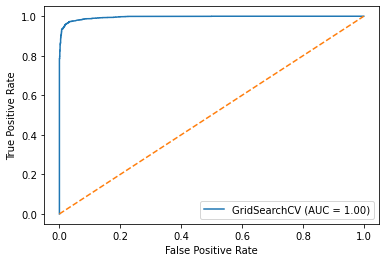

In [35]:
# Plots the ROC curve, and visualizes the AUC score
plot_roc_curve(gs, X_test, y_test)
plt.plot([0,1],[0,1], label='baseline', linestyle='--');

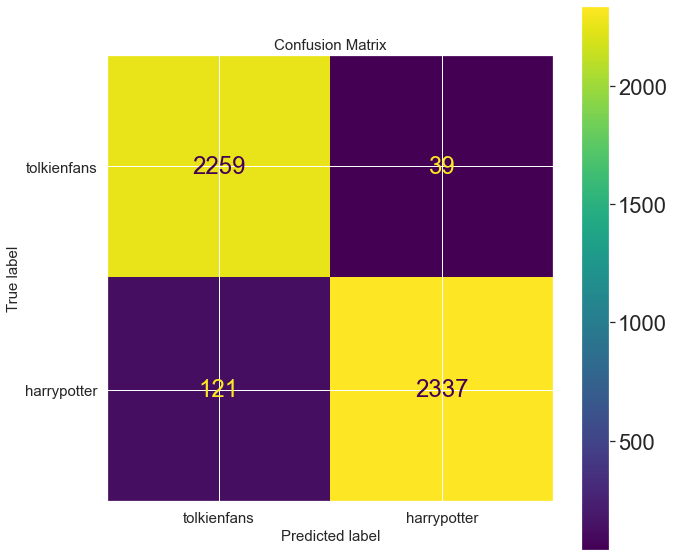

In [36]:
# Creates the confusion matrix and saves it as a jpg in presentation folder
sns.set(font_scale=2.0)
cm = confusion_matrix(y_test, y_preds)
fig, ax = plt.subplots(figsize=(10, 10))
plot = ConfusionMatrixDisplay(cm).plot(ax=ax)
plot
plt.title('Confusion Matrix')
ax.set_title('Confusion Matrix', fontdict={'size':'15'})
ax.set_xticklabels(df['subreddit'].unique(), size=15);
ax.set_yticklabels(df['subreddit'].unique(), size=15);
ax.set_xlabel('Predicted label', fontdict={'size':'15'})
ax.set_ylabel('True label', fontdict={'size':'15'})

plt.savefig('../../../presentation/imgs/cm_logreg_countvect_lem.jpg')

In [37]:
# Creates the coefs dictionary dataframe and prints out the 10 smallest coefficients
coefs = gs.best_estimator_.named_steps['logreg'].coef_
coefs = coefs.ravel()

names = gs.best_estimator_.named_steps['cvec'].get_feature_names()

coef_dict = pd.DataFrame({'coefs': coefs,
                      'features': pd.Series(names)})
coef_dict.nsmallest(10, columns=['coefs'])

,coefs,features
2406,-2.620112,harry
2539,-2.549941,hogwarts
4848,-2.359933,snape
5646,-2.129917,voldemort
2487,-2.119263,hermione
3993,-2.076185,potter
1496,-1.879379,dumbledore
2585,-1.812138,hp
5665,-1.734352,wand
4206,-1.662579,ravenclaw


In [38]:
# Outputs the 10 largest coefficients in a dataframe
coef_dict.nlargest(10, columns=['coefs'])

,coefs,features
5333,5.020076,tolkien
2526,3.685608,hobbit
3158,3.503270,lotr
4769,3.251281,silmarillion
4552,2.480398,sauron
4438,2.424396,ring
1598,2.285897,elf
4549,2.073165,saruman
3437,2.011032,morgoth
3331,1.994274,melkor
